# Week 8

First, we consider principal components analysis (PCA), an *unsupervised* learning method to reduce the dimensionality of a dataset by projecting its points into an optimal lower dimensional vector space.

# Lecture 14 - Principal Components Analysis

The classification methods we have used are quite good at some tasks, such as identifying handwritten digits from the MNIST dataset. Harder problems, like classifying images from the CIFAR-10 dataset, are still a challenge, and are very computationally intensive due to the high dimension data. The next topic in the class will be to try to manage this dimensionality problem.

## Principal Components Analysis (PCA)

Principal components analysis (PCA) is a method for reducing the dimension of the data by using some ideas from linear algebra to map the rows from a data matrix $X$ from its default $d$-dimensional space to an $r$-dimensional space for some $r < d$.

Please see the notes in class for the math that makes this work, but we write an implementation below.

In [1]:
import numpy as np
import seaborn as sn
import time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

In [2]:
# Principal component analysis
def PCA(X, alpha):        
    # find the original dimension and print it
    dimension = X.shape[1]
    print('The original dimension of the data is', dimension)
    
    # center D to have mean 0
    X -= np.mean(X, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/X.shape[0]) * X.T @ X

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varX = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varX

        if ratio > alpha:
            dimension = r + 1
            print('The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = X @ basis
    
    # return points
    return A

To test this out a bit, let's bring in our neural network code and our favorite dataset (MNIST), use PCA to reduce the dimension of MNIST, and then train the neural net to classify the lower-dimensional data.

First, let's run it on MNIST images and compute the time. Later, we will compare it to using PCA and training the net on the resulting data.

Now training QDA...


C:\Users\Ryan\miniconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA training is finished after 2.120912551879883 seconds
Now testing QDA...
QDA prediction is finished after 0.8149929046630859 seconds

Test Classification Report for reg_param = 0.05               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.97      0.94      0.95      1032
           3       0.96      0.94      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.94      0.95       892
           6       0.97      0.97      0.97       958
           7       0.97      0.93      0.95      1028
           8       0.91      0.94      0.93       974
           9       0.92      0.96      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Test Confusion Matrix:



<AxesSubplot:>

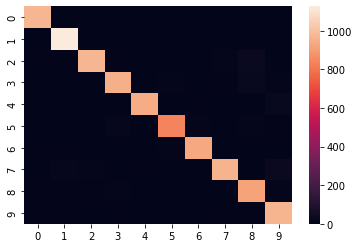

In [3]:
# import MNIST data
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

We achieved 96% accuracy on the test set and the runtime was 2.9 seconds. Now, let's do exactly the same thing *except* we will use PCA to reduce the dimension of the same data before running QDA.

Now using PCA dimensionality reduction...
The original dimension of the data is 784
The new dimension of the data is 43 and it explains 0.8001734877104146 of the variance
PCA finished in 1.9196336269378662 seconds
Now training QDA...
QDA training is finished after 0.060337066650390625 seconds
Now testing QDA...
QDA prediction is finished after 0.04025411605834961 seconds

Test Classification Report for reg_param = 0.05               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1722
           1       0.98      0.98      0.98      2007
           2       0.95      0.97      0.96      1799
           3       0.95      0.94      0.95      1788
           4       0.98      0.97      0.97      1690
           5       0.95      0.97      0.96      1622
           6       0.98      0.97      0.98      1669
           7       0.96      0.95      0.96      1798
           8       0.93      0.94      0.93      1708
           9       0.94      0.94   

<AxesSubplot:>

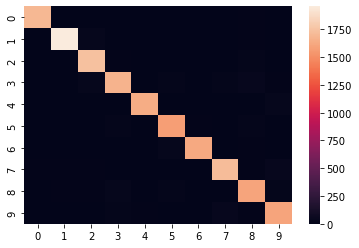

In [4]:
# import MNIST data
(trainX, trainY), (testX, testY) = mnist.load_data()

X = np.vstack((trainX, testX))
Y = np.concatenate((trainY, testY))

# reshape the data
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]).astype('float')

# Use PCA
print('Now using PCA dimensionality reduction...')

start = time.time()

# Apply PCA to the data matrices
X = PCA(X, 0.8)

end = time.time()

print('PCA finished in', end - start, 'seconds')

# normalize the data
X = X / 255.0

# train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Here, requiring a number of dimensions explaining 80\% of the variance of the dataset with PCA reduced the dimension from 784 to 43, a reduction of over 94\%! What is even more amazing is that the test accuracy on the lower-dimensional data is still 96\%, but the time for PCA (1.9 seconds) + training (0.05 seconds) + prediction (0.05 seconds) is only 2 seconds, about 33\% less than the time without it.

Let's try it with CIFAR-10, so let's see if performance improves or at least stays the same when we use PCA.

First, without PCA.

Now training QDA...


C:\Users\Ryan\miniconda3\envs\DL\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


QDA training is finished after 31.361711502075195 seconds
Now testing QDA...
QDA prediction is finished after 6.257355213165283 seconds

Test Classification Report for reg_param = 0.05               precision    recall  f1-score   support

           0       0.55      0.39      0.46      1000
           1       0.88      0.19      0.31      1000
           2       0.33      0.41      0.37      1000
           3       0.30      0.32      0.31      1000
           4       0.31      0.75      0.44      1000
           5       0.44      0.41      0.42      1000
           6       0.92      0.11      0.19      1000
           7       0.84      0.31      0.46      1000
           8       0.33      0.89      0.48      1000
           9       0.81      0.20      0.32      1000

    accuracy                           0.40     10000
   macro avg       0.57      0.40      0.38     10000
weighted avg       0.57      0.40      0.38     10000


Test Confusion Matrix:



<AxesSubplot:>

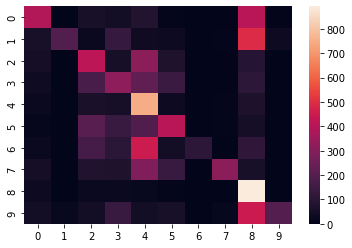

In [5]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], 3 * 32 * 32)
testX = testX.reshape(testX.shape[0], 3 * 32 * 32)

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Next, let's use PCA to shrink the data to a lower dimension and see how the runtime and performance compare with all settings equal.

Now using PCA dimensionality reduction...
The original dimension of the data is 3072
The new dimension of the data is 33 and it explains 0.802687122031818 of the variance
PCA finished in 36.18577599525452 seconds
Now training QDA...
QDA training is finished after 0.06261038780212402 seconds
Now testing QDA...
QDA prediction is finished after 0.02014946937561035 seconds

Test Classification Report for reg_param = 0.05 :
               precision    recall  f1-score   support

           0       0.50      0.55      0.52      1473
           1       0.58      0.52      0.55      1500
           2       0.32      0.24      0.27      1492
           3       0.33      0.31      0.32      1491
           4       0.37      0.49      0.42      1516
           5       0.45      0.34      0.39      1514
           6       0.45      0.61      0.52      1503
           7       0.59      0.50      0.54      1570
           8       0.58      0.60      0.59      1493
           9       0.54      0.54  

C:\Users\Ryan\miniconda3\envs\DL\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:>

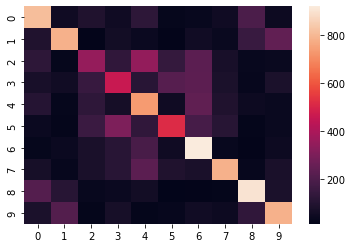

In [6]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

X = np.vstack((trainX, testX))
Y = np.concatenate((trainY, testY))

# reshape the data
X = X.reshape(X.shape[0], 3 * 32 * 32).astype('float')

# Use PCA
print('Now using PCA dimensionality reduction...')

start = time.time()

# Apply PCA to the data matrices
X = PCA(X, 0.8)

end = time.time()

print('PCA finished in', end - start, 'seconds')

# normalize the data
X = X / 255.0

# train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, ':\n', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Performance is still not great, but it is better by 7% test accuracy. We gained accuracy with less computational time! This one took

* 36.2 seconds for PCA
* 0.1 seconds for training and testing

or 36.3 total seconds while training with the original dataset took 37.6 seconds.

Let's try kNN.

Now training kNN...
kNN training is finished after 0.1344003677368164 seconds
Now testing kNN...
kNN prediction is finished after 282.38029050827026 seconds

Test Classification Report               precision    recall  f1-score   support

           0       0.46      0.55      0.50      1000
           1       0.70      0.24      0.36      1000
           2       0.27      0.43      0.33      1000
           3       0.34      0.22      0.27      1000
           4       0.26      0.53      0.35      1000
           5       0.45      0.31      0.37      1000
           6       0.38      0.35      0.36      1000
           7       0.67      0.31      0.42      1000
           8       0.42      0.72      0.53      1000
           9       0.71      0.28      0.40      1000

    accuracy                           0.39     10000
   macro avg       0.47      0.39      0.39     10000
weighted avg       0.47      0.39      0.39     10000


Test Confusion Matrix:



<AxesSubplot:>

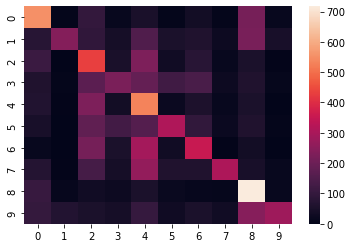

In [7]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], 3 * 32 * 32)
testX = testX.reshape(testX.shape[0], 3 * 32 * 32)

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# fit the model to the training data
print('Now training kNN...')

start = time.time()

model = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', p = 1, n_jobs = -1)
model.fit(trainX, trainY.ravel())

end = time.time()

print('kNN training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing kNN...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('kNN prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Next, let's use PCA to shrink the data to a lower dimension and see how the runtime and performance compare with all settings equal.

Now using PCA dimensionality reduction...
The original dimension of the data is 3072
The new dimension of the data is 33 and it explains 0.802687122031818 of the variance
PCA finished in 36.00750112533569 seconds
Now training kNN...
kNN training is finished after 0.020329952239990234 seconds
Now testing kNN...
kNN prediction is finished after 7.995319366455078 seconds

Test Classification Report               precision    recall  f1-score   support

           0       0.49      0.58      0.53      1473
           1       0.64      0.35      0.45      1500
           2       0.30      0.41      0.35      1492
           3       0.37      0.21      0.27      1491
           4       0.30      0.45      0.35      1516
           5       0.45      0.28      0.34      1514
           6       0.34      0.57      0.43      1503
           7       0.61      0.40      0.48      1570
           8       0.50      0.65      0.56      1493
           9       0.59      0.36      0.44      1448

    a

<AxesSubplot:>

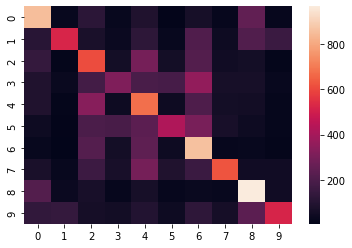

In [8]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

X = np.vstack((trainX, testX))
Y = np.concatenate((trainY, testY))

# reshape the data
X = X.reshape(X.shape[0], 3 * 32 * 32).astype('float')

# Use PCA
print('Now using PCA dimensionality reduction...')

start = time.time()

# Apply PCA to the data matrices
X = PCA(X, 0.8)

end = time.time()

print('PCA finished in', end - start, 'seconds')

# normalize the data
X = X / 255.0

# train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
print('Now training kNN...')

start = time.time()

model = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', p = 1, n_jobs = -1)
model.fit(trainX, trainY.ravel())

end = time.time()

print('kNN training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing kNN...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('kNN prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

## PCA for Visualization

Let's import some libraries

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Let's apply PCA to the MNIST dataset to reduce it to 2 dimensions.

In [14]:
# read the MNIST data
(X, Y), _ = mnist.load_data()

# reshape the datapoints into rows
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

# create a PCA model with two components
pca = PCA(n_components = 2)

# transform the data
A = pca.fit_transform(X)

In [15]:
# print the amount of variance explained by each component
print(pca.explained_variance_ratio_)

[0.09704664 0.07095924]


Let's next visualize the first two principal components for MNIST.

Text(0.5, 1.0, '7.10% Explained Variance')

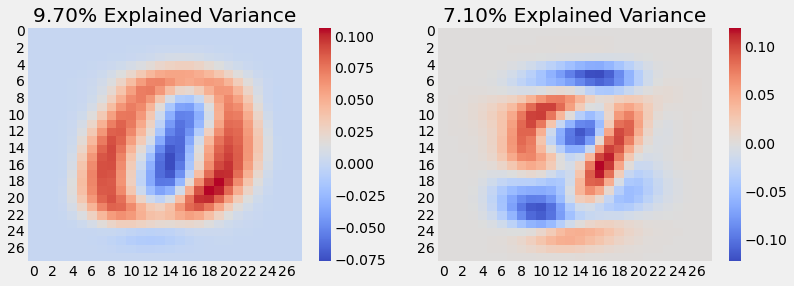

In [17]:
# set the style
plt.style.use('fivethirtyeight')

# declare a 1-by-2 plot
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

# plot heatmaps of PCA components and shape into a square
sn.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap='coolwarm')
sn.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap='coolwarm')

# set chart titles
axarr[0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100))
axarr[1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100))